Este código crea una función que me permite estimar la varianza de una distribución y lo chequea con las distribuciones de Poisson y Gauss. Además, usa el método boostrap resampling que se basa en, a partir de una muestra, se crea una población y luego se toman muestras de la misma.

Ésto permite medir un estadístico, por ej. la varianza, tantas veces como se quiera y luego tener un intervalo de confianza para el mismo.


-----
El cógido genera una función que me premite calcular la varianza de una distribución y luego crea otra función que, usando el método de boostrap resampling, me devuelve el intervalo de confianza para cierto nivel de significancia y también me da la distribución de varianzas medidas

In [1]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
# Estilo de gráficos
plt.style.use('dark_background')

In [2]:
# Estilo de gráficos
plt.style.use('dark_background')

In [3]:
def Var(X):
    """ Devuelve la varianza un arreglo
    
    Parameters
    ----------
    X : np.darray()
        Arreglo de valores de una variable aleatoria
        
    Returns
    -------
    Var : .float
        Varianza del arreglo X
    
    """
    import numpy as np 
    # La varianza es el momento de orden 2 de la distribución discreta, la calculo:
    Var = np.sum((X-np.mean(np.array(X)))**2)/len(X)
    return Var

Para probarla uso dos distribuciones conocidas: gaussiana y Poisson. Para la de Poisson traigo mi propia función generadora

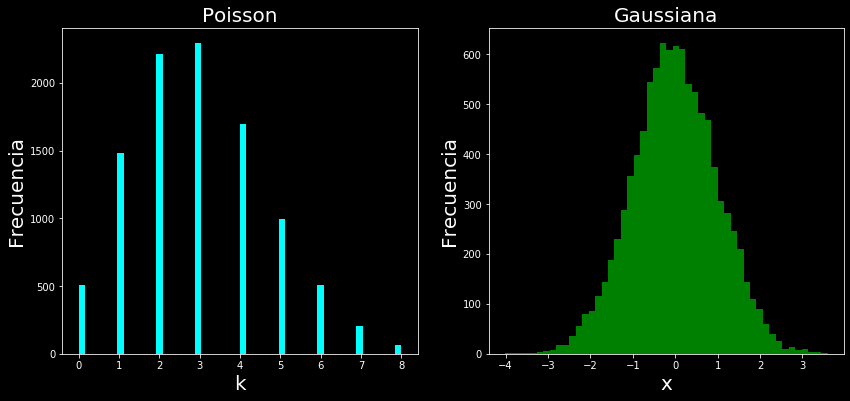

In [4]:
# Creo las dos distribuciones:
Puntos = 10000
# Poisson
from Misfunciones import Poisson # Usar help(Poisson) para ver detalles
Lambd = 3 # Teóricamente es la media y la varianza
XP = Poisson(lambd=Lambd, N=Puntos)
# Gauss
dev = 1 # desviación estándar
XG = np.random.normal(0, dev, Puntos)

# Grafico
fig, ax = plt.subplots(1, 2, figsize = (14,6))

ax[0].hist(XP, color='cyan', bins=50);
ax[1].hist(XG, color='green', bins=50);

ax[0].set_title('Poisson', fontsize=20)
ax[0].set_ylabel('Frecuencia', fontsize=20)
ax[0].set_xlabel('k', fontsize=20)
ax[1].set_title('Gaussiana', fontsize=20)
ax[1].set_ylabel('Frecuencia', fontsize=20)
ax[1].set_xlabel('x', fontsize=20);

In [5]:
# Calculo varianzas:
VarXP = Var(np.array(XP))
print('Varianza teórica Poisson =', Lambd)
print('Varianza obtenida Poisson =', VarXP)
VarXG = Var(XG)
print('Varianza teórica Gauss =', dev**2)
print('Varianza obtenida Gauss =', VarXG)

Varianza teórica Poisson = 3
Varianza obtenida Poisson = 2.803882714309116
Varianza teórica Gauss = 1
Varianza obtenida Gauss = 0.9891229637633558


No es extremadamente precisa pero funciona. Probé calcularla con np.var(XP) y da lo mismo

Ahora defino la función Boostrap_var() que requiere tener cargada la función Var(). Podría usar la función np.var() pero creo que eso no es lo que se pide.

In [6]:
def Boostrap_var(Sample, N, Mult, alpha):
    """ Usa el método boostrap resampling para tener la incerteza de la varianza de una muestra
    
    Parameters
    ----------
    
    Sample : np.ndarray()
        Muestra de la variable aleatoria
    N : int
        Cantidad de resamplings. Valor positivo mayor a cero
    Mult : int
        Multiplicador para crear la población de tamaño M*len(Sample)
    alpha : .float
        Nivel de significancia deseado, pertenece a (0,1). Si se quiere 95% => alpha=0.95. 
    
    Returns
    -------
    .float
        Valor inferior del intervalo de confianza
    .float
        Valor superior del intervalo de confianza
    np.darray()
        Arreglo de las medias de las varianzas
    """
    # Errores
    if N<1 or isinstance(N, int)==False:
        raise ValueError('Error: N debe ser una entero positivo')
    if alpha<0 or alpha>=1:
        raise ValueError('Error: Alpha debe pertenecer al intervalo (0,1)')
    # -------
    import numpy as np
    # Creo una población de tamaño M*len(Samples)
    # Básicamente copio y pego la muestra M veces
    Pop = []
    ij = 0
    while ij<Mult:
        ik = 0
        while ik<len(Sample):
            Pop.append(Sample[ik])
            ik = ik + 1
        ij = ij + 1
    # Tomo N samples DE ESA POBLACIÓN de tamaño len(Sample) y le calculo la varianza a c/u
    ij = 0
    Vars = []
    while ij<N:
        Resampling = np.random.choice(Pop, size=len(Sample))
        Vars.append( Var(Resampling) )
        ij = ij + 1
    # Transformo a array de Numpy
    Vars = np.array(Vars)
    
    # Calculos los intervalos de confianza ------------------------
    Dsort = np.sort(Vars) # Ordeno los valores de las varianzas
    # Encuentro el ij correspondiente a la media, lo llamo "ijm"
    ij = 0
    while ij<len(Dsort):
        EA = sum(Dsort<=Dsort[ij])/len(Dsort) # Estimación del área
        if EA>=0.5: # media --> 0.5 del área estimada
            ijm = ij
            break
        ij = ij + 1
    # Suponiendo intervalos de confianza simétricos busco el intervalo de confianza:
    ij = ijm
    while ij<len(Dsort):
        # Cuento los "True". Esto es la estimación de un área para una distrib. discreta
        EA = sum(Dsort<=Dsort[ij])/len(Dsort) # Empieza con el valor "0.5" para ij=ijm
        if EA>0.5+alpha/2:
            sup = Dsort[ij]                       # parte superior del intervalo 
            inf = Dsort[ijm] - (sup - Dsort[ijm]) # Parte inferior del intervalo
            break 
        ij = ij + 1
    return inf, sup, Dsort

In [7]:
# Ejemplo
N1 = 1000
M1 = 10
alpha1 = 0.95

D = Boostrap_var(XG, N=N1, Mult=M1, alpha=alpha1) # Distribución calculada

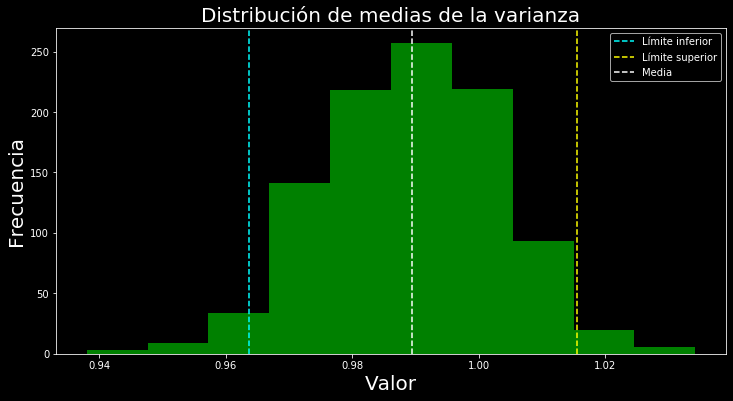

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))

ax.hist(D[2], color='green');
ax.axvline(D[0], ls='--', color='cyan', label='Límite inferior')
ax.axvline(D[1], ls='--', color='yellow', label='Límite superior')
ax.axvline(np.mean(D[2]), ls='--', color='white', label='Media')

ax.set_title('Distribución de medias de la varianza', fontsize=20)
ax.set_xlabel('Valor', fontsize=20)
ax.set_ylabel('Frecuencia', fontsize=20);
ax.legend();

Ahora veré si el nivel de significancia calculado contiene al valor correcto de la varianza

In [9]:
# Recordar que la varianza teórica de la gaussiana la definí como "VarXG"
print('El intervalo de confianza del %',100*alpha1, 'es: (', round(D[0],3),
      ',', round(D[1],3), ')')
print('La varianza teórica es:', round(VarXG,3))
# Condición
if VarXG>D[0] and VarXG<D[1]:
    print('Resultado: Si, los resultados con compatibles')
else: 
    print('Resultado: No, los resultados no son compatibles')

El intervalo de confianza del % 95.0 es: ( 0.964 , 1.016 )
La varianza teórica es: 0.989
Resultado: Si, los resultados con compatibles
